## Decision Tree Classifier

Implement some helper functions that would be necessary for a home-grown tree:
  - calc_entropy
  - calc_gini
  
Calculate the gain ratio in the case of splitting the data up into individual council areas.

In [1]:
# import the libraries!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import log2
from sklearn import tree # Yes, you get to use scikit-learn this assignment, but only when \I say!
import graphviz


## Q1 Load the Data
Load in the melb_tree_train.csv into a dataframe, and split that dataframe into `df_X` containing the features of the data set (everything but `Type`), and `s_y`, the series containing just the label column (just `Type`)

In [25]:
df = pd.read_csv("melb_tree_train.csv")
# every feature but Type
df_x = df[['Rooms', 'Price', 'Distance','Bedroom2', 'Bathroom', 'Car', 
           'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea']]
df_y = df[['Type']]
# the series containing Type
s_y = df_y.squeeze()
s_y



0      t
1      t
2      u
3      h
4      u
      ..
805    t
806    u
807    t
808    t
809    h
Name: Type, Length: 810, dtype: object

## Q2 Define the entropy function
Implement a function `calc_entropy` that takes the labels series, s_y, as a parameter. Implement using the definition on p128 in the DM book and only pandas and log2 libraries

In [3]:
def calc_entropy(s_y):
    tot = s_y.size
    entropy = 0
    for x in s_y.value_counts():
        entropy += (float(x) / tot) * log2(float(x) / tot)
    entropy *= -1
    
    return entropy

## Q3 Use the entropy function to
  - (a) Calculate the entropy of the entire training set
  - (b) Calculate the entropy of the three partitions formed from 
    * Landsize $\in$ (0,200]
    * Landsize $\in$ (200,450]
    * Landsize $\in$ (450, $\infty$)

In [4]:
# a
calc_entropy(s_y)

1.5825333114261775

In [5]:
b_1 = df.loc[df['Landsize'] <= 200]
b_1s = b_1['Type'].squeeze()
calc_entropy(b_1s)

1.3456432116206725

In [6]:
b_2 = df.loc[(df['Landsize'] <= 450) & (df['Landsize'] > 200)]
b_2s = b_2['Type'].squeeze()
calc_entropy(b_2s)

1.4660501816027978

In [7]:
b_3 = df.loc[df['Landsize'] > 450]
b_3s = b_3['Type'].squeeze()
calc_entropy(b_3s)

1.09954792005911

## Q4 Define the Gini Index
Implement the function `calc_gini` that takes the labels series, s_y, as a parameter. Implement using the definition on p128 in the DM book.  Use only pandas library

In [8]:
def calc_gini(s_y):
    tot = s_y.size
    gini = 0
    for x in s_y.value_counts():
        gini += (float(x) / tot) * (float(x) / tot)
    gini = 1 - gini    
    return gini

## Q5 Use the Gini Index function to
  - (a) Calculate the Gini index of the entire training set
  - (b) Calculate the Gini index of the three partitions formed from 
    * Landsize $\in$ (0,200]
    * Landsize $\in$ (200,450]
    * Landsize $\in$ (450, $\infty$)

In [9]:
# entire training set
calc_gini(s_y)

0.6655601280292638

In [10]:
# Landsize (0, 200]
calc_gini(b_1s)

0.5741211482422965

In [11]:
# Landsize (200, 450]
calc_gini(b_2s)

0.6101021682602731

In [12]:
# Landsize (450, infinity)
calc_gini(b_3s)

0.43819341715976323

## Q6 Calculate Gain Ratio using unique council area
Calculate the gain ratio (p135) going from the root node, to splitting that node into 29 child nodes based on their `CouncilArea`, where each child node contains a single council area.

In [19]:
# calculating entropy of parent
entropy_parent = calc_entropy(s_y)
tdf = df[['CouncilArea', "Type"]]
# dict with keys as council area and values as 'Type' column
dfs = dict(tuple(tdf.groupby('CouncilArea')))

ca_tot = tdf['CouncilArea'].size
entropy_child = 0

#iterating through the dict
for v in dfs.values():
    # calculating probability of each council area
    v['Prob'] = (v['CouncilArea'].size)/ca_tot
    # calculating entropy of child
    entropy_child += v['Prob'].iloc[0] * calc_entropy(v['Type'])
    
split_info = calc_entropy(tdf['CouncilArea'].squeeze())
gain_ratio = (entropy_parent - entropy_child)/split_info
gain_ratio
print(dfs)

{'Banyule':     CouncilArea Type      Prob
1       Banyule    t  0.053086
29      Banyule    t  0.053086
76      Banyule    h  0.053086
92      Banyule    h  0.053086
110     Banyule    t  0.053086
139     Banyule    u  0.053086
156     Banyule    t  0.053086
165     Banyule    t  0.053086
177     Banyule    h  0.053086
181     Banyule    u  0.053086
191     Banyule    t  0.053086
212     Banyule    t  0.053086
222     Banyule    h  0.053086
237     Banyule    u  0.053086
239     Banyule    u  0.053086
262     Banyule    h  0.053086
302     Banyule    h  0.053086
308     Banyule    h  0.053086
346     Banyule    t  0.053086
361     Banyule    h  0.053086
368     Banyule    h  0.053086
395     Banyule    u  0.053086
460     Banyule    t  0.053086
492     Banyule    h  0.053086
493     Banyule    t  0.053086
509     Banyule    u  0.053086
521     Banyule    h  0.053086
543     Banyule    u  0.053086
551     Banyule    h  0.053086
563     Banyule    t  0.053086
568     Banyule    h  0.053

## Q7 Create a decision tree 
Using [scikit-learn](https://scikit-learn.org/stable/modules/tree.html#tree) create a multi class classifer for the data set using the Entropy impurity measure and a max depth of 3

Note that scikit-learn's algorithm doesn't handle categorical data, so that needs to be preprocessed using an one hot encoding.

Display the tree using `export_text` from sklearn.tree, and use that information to write some descriptive analytics on the classification of houses.  For extra fun, use the export_graphviz to draw the graph (see documentation on the [scikit-learn webpage](https://scikit-learn.org/stable/modules/tree.html#classification).  If you are on a Windows system and get stuck reach out in the homework channel to see if anyone else could get it working for tips and tricks.  If enough people with Windows can't make the visualization, I won't count it toward the homework grade.

In [14]:
# use get_dummies() to create the one-hot sequence.
# council area encodings
council_en = pd.get_dummies(pd.Series(df['CouncilArea']), dtype=np.int64)


# Add the column to the df.
df_new = df.join(council_en)
df_new = df_new.drop(columns = ['CouncilArea', 'Type'])

clf = tree.DecisionTreeClassifier(max_depth = 3, criterion = "entropy")
clf = clf.fit(df_new, df['Type'])

# create tree diagram
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

##  Some Descriptive Analytics
The tree diagram shows each division within the data, and the weight for each branch. The root node makes the highest-weighted decision in order to predict the house type. The weightage is determined by the entropy. `X[8] <= 1977.5` (A house having been built before 1977.5) was determined to be the "strongest" factor that determines the type of house built. 

## Q8 Calculate the Accuracy and Display Learning Curve
Load in the test data.

Use the scikit-learn library to create decision trees with the following configurations

    - Vary the max level from 2 to 15 with the Gini Index as the impurity measure
    - Vary the max leven from 2 to 15 with the Entropy as the impurity measure


Evaluate the accuracy of each decision tree with both the 
  - Training set
  - Test set

Display the results graphicaly, and offer an analysis of the trend (or if no trend present, offer a hypotheisis of why).  The max number of levels should be on the x-axis, the error rate should be on the y-axis (see figure 3.23 for a similar graph).

In [15]:
gini_train = []
gini_test = []
entropy_train = []
entropy_test = []

# lists for accuracies (used in the analysis part later, pls ignore)
gini_train_a = []
gini_test_a = []
entropy_train_a = []
entropy_test_a = []

df_test = pd.read_csv("melb_tree_test.csv")
df_testX = df_test[['Rooms', 'Price', 'Distance','Bedroom2', 'Bathroom', 'Car', 
           'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea']]

# council area encodings
council_en = pd.get_dummies(pd.Series(df_test['CouncilArea']), dtype=np.int64)
# Add the column to the df.
df_testX = df_test.join(council_en)
df_testX = df_testX.drop(columns = ['CouncilArea', 'Type'])


y_truth_train = df['Type'].to_numpy()
y_truth_test = df_test['Type'].to_numpy()

for tree_depth in range(2, 16):

    # create new tree for gini
    clf_gini = tree.DecisionTreeClassifier(max_depth = tree_depth, criterion = "gini")
    
    # use training set
    clf_gini = clf_gini.fit(df_new, df['Type'])
    y_hat = clf_gini.predict(df_new)
    gini_train.append(1 - np.count_nonzero(y_truth_train==y_hat) / np.size(y_hat))
    gini_train_a.append(np.count_nonzero(y_truth_train==y_hat) / np.size(y_hat))

    
    # use test set
    y_hat = clf_gini.predict(df_testX)
    gini_test.append(1 - np.count_nonzero(y_truth_test==y_hat) / np.size(y_hat))
    gini_test_a.append(np.count_nonzero(y_truth_test==y_hat) / np.size(y_hat))


    # create new tree for entropy
    clf_entropy = tree.DecisionTreeClassifier(max_depth = tree_depth, criterion = "entropy")

    # use training set
    clf_entropy = clf_entropy.fit(df_new, df['Type'])
    y_hat = clf_entropy.predict(df_new)
    entropy_train.append(1 - np.count_nonzero(y_truth_train==y_hat) / np.size(y_hat))
    entropy_train_a.append(np.count_nonzero(y_truth_train==y_hat) / np.size(y_hat))

    # use test set
    y_hat = clf_entropy.predict(df_testX)
    entropy_test.append(1 - np.count_nonzero(y_truth_test==y_hat) / np.size(y_hat))
    entropy_test_a.append(np.count_nonzero(y_truth_test==y_hat) / np.size(y_hat))

    clf_gini = None
    clf_entropy = None
    
    
# print(gini_train)
# print(gini_test)
# print(entropy_train)
# print(entropy_test)

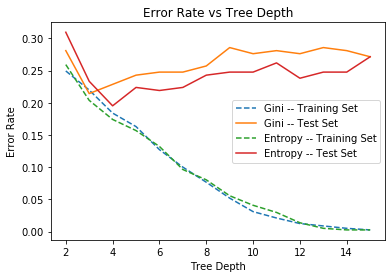

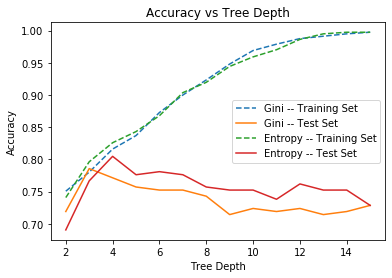

In [16]:
x_range = [x for x in range(2, 16)]

# create the plot
plt.plot(x_range, gini_train, label='Gini -- Training Set', linestyle='--')
plt.plot(x_range, gini_test, label='Gini -- Test Set')
plt.plot(x_range, entropy_train, label='Entropy -- Training Set', linestyle='--')
plt.plot(x_range, entropy_test, label='Entropy -- Test Set')
plt.title("Error Rate vs Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")
plt.legend()
plt.show()

# create the plot (this is extra, just to show accuracy since we were curious)
plt.plot(x_range, gini_train_a, label='Gini -- Training Set', linestyle='--')
plt.plot(x_range, gini_test_a, label='Gini -- Test Set')
plt.plot(x_range, entropy_train_a, label='Entropy -- Training Set', linestyle='--')
plt.plot(x_range, entropy_test_a, label='Entropy -- Test Set')
plt.title("Accuracy vs Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Analysis of Learning Curve(s)

The general trend was that increasing the overall depth of the tree would increase the accuracy of the training-set predictions, while decreasing the accuracy of the test-set predictions. From our graphs above, this is reinforced.

Both the graphs demonstrate that our model overfits when the Tree Depth crosses around 4 levels for both Gini and Entropy. The lines showing the test-set prediction accuracy and error-rate inflect, then negatively correlated with tree depth.
Our model overfits the training data as the depth increases, this makes the model less generalizable, causing the inflection of test-set lines.
